In [1]:
import numpy as np
import time
import os
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.constraints import non_neg
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, UpSampling1D, UpSampling2D, UpSampling3D
from keras.layers import Conv2D, Conv1D, MaxPooling2D, BatchNormalization
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import backend
from scipy import misc
from keras.models import model_from_json
from skimage.transform import resize

##Modify Parameters Here
bands=4
hr_img_size=(450,450)
inpt_lr_img_size=(135,135)
sptlvarmeasure=32

Using TensorFlow backend.


In [2]:
def array_from_tif_dir(tifdir,res):
    finaldim=(len(os.listdir(os.getcwd() + '/tifs/' + tifdir)),res,res,4)
    finalset=np.zeros(finaldim)
    imgcounter=0
    for imagename in os.listdir(os.getcwd() + '/tifs/' + tifdir):
        image = misc.imread(os.getcwd() + '/tifs/' + tifdir + imagename)
        finalset[imgcounter,:,:,:]= image
        imgcounter+=1
    return(finalset)
y_train=array_from_tif_dir('HR/',hr_img_size[0])
y_test=array_from_tif_dir('HRV/',hr_img_size[0])
X_train=array_from_tif_dir('LR/',inpt_lr_img_size[0])
X_test=array_from_tif_dir('LRV/',inpt_lr_img_size[0])
        
        

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [3]:



# newximglist=[]
# newx2imglist=[]
# imagecounter=0
# # for image in X_train:
# #     preimage=np.swapaxes(image.copy(),0,-1)
# #     newximage=misc.imresize(preimage.copy(), inpt_lr_img_size)
# #     finalimage=np.swapaxes(newximage.copy(),0,-1)
# #     newximglist.append(finalimage.copy())
# #     imagecounter+=1
# # X_train=np.array(newximglist)
# # for image in X_test:
# #     preimage=np.swapaxes(image.copy(),0,-1)
# #     newximage=misc.imresize(preimage.copy(), inpt_lr_img_size)
# #     finalimage=np.swapaxes(newximage.copy(),0,-1)
# #     newx2imglist.append(finalimage.copy())
# #     imagecounter+=1
# X_test=np.array(newx2imglist)
y_train=np.swapaxes(y_train,1,-1)
y_test=np.swapaxes(y_test,1,-1)
X_train=np.swapaxes(X_train,1,-1)
X_test=np.swapaxes(X_test,1,-1)
print(X_test.shape)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)

# 5. Preprocess input data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')[0:10] 
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')[0:10]
X_train /= 255
X_test /= 255
y_train /= 255
y_test /= 255


(153, 4, 135, 135)
(925, 4, 135, 135)
(925, 4, 450, 450)
(153, 4, 450, 450)


In [31]:

 
# 7. Define model architecture
model = Sequential()
ilis=inpt_lr_img_size[0]
ihis=hr_img_size[0]
ratio=float(ilis)/float(ihis)
collapsesize=int((ratio**3)*ihis)+1
solved=int((ilis-collapsesize+10)/8)
bands=1

model.add(Conv2D(filters=bands*3, kernel_size=(int(solved), int(solved)), data_format='channels_first', activation='relu', input_shape=(4,ilis,ilis)))
model.add(Conv2D(filters=bands*3, kernel_size=(int(solved), int(solved)), data_format='channels_first', activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.1))

model.add(Conv2D(filters=bands*4, kernel_size=(int(solved), int(solved)), data_format='channels_first', activation='relu'))
model.add(Conv2D(filters=bands*4, kernel_size=(int(solved), int(solved)), data_format='channels_first', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=bands*5, kernel_size=(int(solved), int(solved)), data_format='channels_first', activation='relu'))
model.add(Conv2D(filters=bands*5, kernel_size=(int(solved), int(solved)), data_format='channels_first', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Conv2D(filters=bands*6, kernel_size=(int(solved/2), int(solved/2)), data_format='channels_first', activation='relu'))
model.add(Conv2D(filters=bands*6, kernel_size=(int(solved/2), int(solved/2)), data_format='channels_first', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Conv2D(filters=bands*7, kernel_size=(int(solved/2), int(solved/2)), data_format='channels_first', activation='relu'))
model.add(Conv2D(filters=bands*7, kernel_size=(int(solved/2), int(solved/2)), data_format='channels_first', activation='relu'))
currentsize=model.layers[-1].get_output_at(0).get_shape().as_list()[-1]
reduceneed=currentsize-collapsesize
model.add(BatchNormalization())
model.add(Dropout(0.35))

print(reduceneed)
model.add(Conv2D(filters=bands*7, kernel_size=(reduceneed+1, reduceneed+1), data_format='channels_first', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(UpSampling2D((int(1/ratio*3),int(1/ratio*3)),data_format='channels_first'))
print(int(1/ratio*3))
model.add(Conv2D(filters=bands*7, kernel_size=(int(solved/2), int(solved/2)), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=bands*7, kernel_size=(int(solved/2), int(solved/2)), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())


model.add(UpSampling2D((int(1/ratio)/2,int(1/ratio)/2),data_format='channels_first'))
print(int(1/ratio*2))
model.add(Conv2D(filters=bands*6, kernel_size=(int(solved/2), int(solved/2)), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=bands*6, kernel_size=(int(solved/2), int(solved/2)), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D((int(1/ratio*1.5),int(1/ratio*1.5)),data_format='channels_first'))
model.add(Conv2D(filters=bands*5, kernel_size=(int(solved/1.5), int(solved/1.5)), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=bands*5, kernel_size=(int(solved/1.5), int(solved/1.5)), data_format='channels_first', kernel_constraint=non_neg(), activation='relu'))
currentsize=model.layers[-1].get_output_at(0).get_shape().as_list()[-1]
bandcollapse=model.layers[-1].get_output_at(0).get_shape().as_list()[1]
reduceneed=currentsize-hr_img_size[0]
model.add(BatchNormalization())


model.add(Conv2D(filters=4, kernel_size=(reduceneed+1, reduceneed+1), data_format='channels_first', activation='relu'))




 
# 8. Compile model
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_absolute_error',
              optimizer=opt,
              metrics=['accuracy'])





4
10
6


In [32]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_307 (Conv2D)          (None, 3, 120, 120)       3075      
_________________________________________________________________
conv2d_308 (Conv2D)          (None, 3, 105, 105)       2307      
_________________________________________________________________
batch_normalization_213 (Bat (None, 3, 105, 105)       420       
_________________________________________________________________
conv2d_309 (Conv2D)          (None, 4, 90, 90)         3076      
_________________________________________________________________
conv2d_310 (Conv2D)          (None, 4, 75, 75)         4100      
_________________________________________________________________
batch_normalization_214 (Bat (None, 4, 75, 75)         300       
_________________________________________________________________
dropout_90 (Dropout)         (None, 4, 75, 75)         0         
__________

In [ ]:
if os.path.isfile('model.json'):
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")
opt = optimizers.Adam(lr=.06, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
print(X_train.shape)
tensorboard = TensorBoard(log_dir=os.getcwd()+'/logs'.format(time.time()))
writer = tf.summary.FileWriter(os.getcwd()+'/logs').add_graph(sess.graph)
try:
  loaded_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
  loaded_model.fit(X_train, y_train, 
              batch_size=8, nb_epoch=1, verbose=1, callbacks=[tensorboard])
  model=loaded_model
except (NameError, ValueError) as e:
    model.fit(X_train, y_train, 
              batch_size=8, nb_epoch=1, verbose=1, callbacks=[tensorboard])
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")




Instructions for updating:
Use `tf.global_variables_initializer` instead.
(925, 4, 135, 135)


/usr/local/lib/python2.7/dist-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1


In [22]:
score = model.evaluate(X_test, y_test, verbose=1)
class_scores= model.predict(X_test)
print(score)

10/10 [==============================] - 0s 3ms/step
[0.246853306889534, 0.03437500074505806]


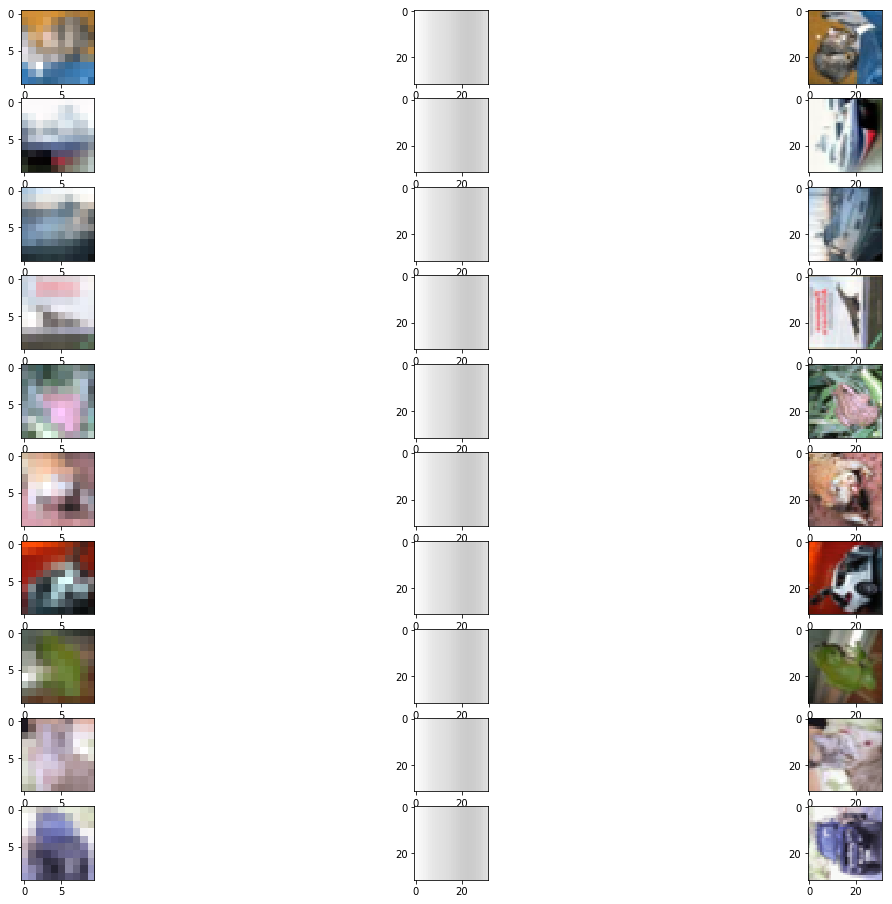

In [21]:
import matplotlib.pyplot as plt
classes=[]
for image in class_scores:
    thisclass=image
    classes.append(thisclass)
f, ax = plt.subplots(10,3, figsize=(20, 16))
axind0=0
axind1=0
imagecounter=0
for image in X_test:
    axind0=imagecounter
    emptyximage=np.zeros((10,10,3))
    emptyyimage=np.zeros((32,32,3))
    emptytargetimage=np.zeros((32,32,3))
    for band in range(1,4):
        newximage=np.abs(image[band-1:band,0:10,0:10])
        newtargetimage=y_test[imagecounter][band-1:band,0:32,0:32]
        newyimage=np.abs(classes[imagecounter][band-1:band,0:32,0:32])
        emptyximage[:,:,band-1:band]=newximage.reshape((10,10,1))*(1/np.max(newximage))
        emptyyimage[:,:,band-1:band]=newyimage.reshape((32,32,1))*(1/np.max(newyimage))
        emptytargetimage[:,:,band-1:band]=newtargetimage.reshape((32,32,1))*(1/np.max(newtargetimage))
    imagecounter+=1
    ax[axind0,0].imshow(emptyximage)
    ax[axind0,1].imshow(emptyyimage)
    ax[axind0,2].imshow(emptytargetimage)
    
    
    